# EDA Radar de Amazon

Voy a hacer un analisi en profundidad sobre los best sellers de amazon india para encontrar un producto ganador que funcione que poder copiar mejorandolo

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import os
print(os.getcwd()) 

c:\Users\ferna\Desktop\EDA_Dropshipping\EDA_Dropshipping\EDA-Amazon\src\Memoria


In [54]:

amazon = pd.read_csv('../data/amazon.csv')

#Descripcion
print("Estadísticas descriptivas:")
print(amazon.describe())

print("\n" + "="*50 + "\n")

#Ver los nombres de las columnas
print("Columnas disponibles:")
print(amazon.columns.tolist())

#Op.2: Ver nombres de las columnas
amazon.columns

Estadísticas descriptivas:
        product_id  \
count         1465   
unique        1351   
top     B08WRWPM22   
freq             3   

                                                                                                                                                     product_name  \
count                                                                                                                                                        1465   
unique                                                                                                                                                       1337   
top     Fire-Boltt Ninja Call Pro Plus 1.83" Smart Watch with Bluetooth Calling, AI Voice Assistance, 100 Sports Modes IP67 Rating, 240*280 Pixel High Resolution   
freq                                                                                                                                                            5   

                                    

Index(['product_id', 'product_name', 'category', 'discounted_price',
       'actual_price', 'discount_percentage', 'rating', 'rating_count',
       'about_product', 'user_id', 'user_name', 'review_id', 'review_title',
       'review_content', 'img_link', 'product_link'],
      dtype='object')

In [ ]:
#Cuantas categorias hay

amazon_exploded = amazon.assign(category=amazon["category"].str.split("|")).explode("category")
amazon_exploded["category"] = amazon_exploded["category"].str.strip()

amazon_exploded["category"].nunique()


317

In [ ]:
#Cuantos productos por categoria hay 

amazon_exploded["category"].value_counts().head(20)

category
Electronics                   526
Computers&Accessories         453
Home&Kitchen                  448
Accessories&Peripherals       381
Kitchen&HomeAppliances        308
Cables                        267
Cables&Accessories            240
USBCables                     233
SmallKitchenAppliances        181
HomeTheater,TV&Video          162
Mobiles&Accessories           161
Heating,Cooling&AirQuality    116
Accessories                   111
MobileAccessories              84
Vacuum,Cleaning&Ironing        82
Smartphones&BasicMobiles       77
SmartWatches                   76
WearableTechnology             76
Televisions                    69
Smartphones                    68
Name: count, dtype: int64

                  category  num_productos
0              Electronics            526
1    Computers&Accessories            453
2             Home&Kitchen            448
3  Accessories&Peripherals            381
4   Kitchen&HomeAppliances            308


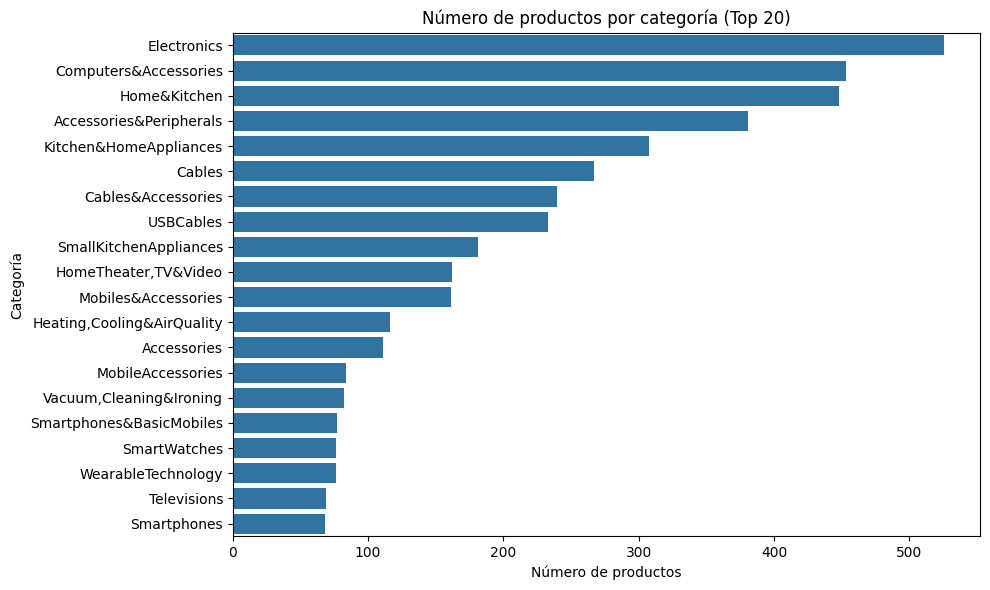

In [56]:

#Grafico representando todas las categorias diferentes 

#Conteo con nombres correctos
categorias = (
    amazon_exploded["category"]
      .value_counts()
      .rename_axis("category")        # índice -> columna 'category'
      .reset_index(name="num_productos")  # conteo -> 'num_productos'
)

# 2) Top 20
top20 = categorias.head(20)


print(top20.head())

# 3) Gráfico
plt.figure(figsize=(10, 6))
sns.barplot(data=top20, x="num_productos", y="category")
plt.title("Número de productos por categoría (Top 20)")
plt.xlabel("Número de productos")
plt.ylabel("Categoría")
plt.tight_layout()
plt.show()


C:\Users\ferna\AppData\Local\Temp\ipykernel_42772\2300320002.py:45: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(topk_with_other_apar, k=3)


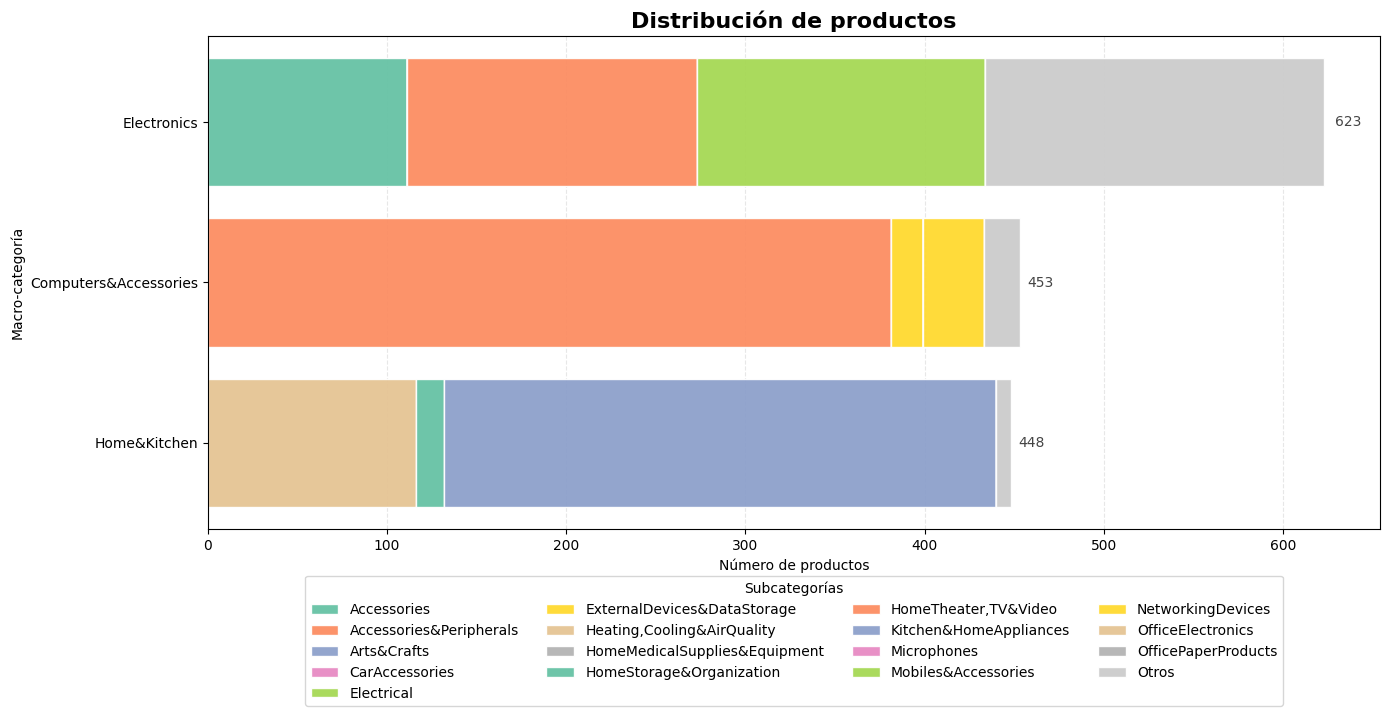

In [ ]:
#Como se dividen las categorias que engloban el mayor porcentaje de productos

routes = amazon[["product_id","category"]].copy()
routes["parts"] = routes["category"].astype(str).str.strip().str.split("|")
routes["L1"] = routes["parts"].apply(lambda xs: xs[0].strip() if isinstance(xs, list) and len(xs)>0 else np.nan)
routes["L2"] = routes["parts"].apply(lambda xs: xs[1].strip() if isinstance(xs, list) and len(xs)>1 else np.nan)


macros_labels = routes["L1"].dropna().unique().tolist()
l1_l2_pairs  = (routes.dropna(subset=["L1","L2"])
                        [["L1","L2"]]
                        .drop_duplicates())

#Conteo por productos
label_counts = (amazon_exploded["category"].astype(str)
                                   .str.strip()
                                   .value_counts())

# macro: nº de productos
macro_apar = (label_counts[label_counts.index.isin(macros_labels)]
              .rename_axis("L1")
              .reset_index(name="n_macro_apar"))

l2_counts = (label_counts.rename_axis("L2").reset_index(name="n_l2_apar"))


subs_apar = (l1_l2_pairs.merge(l2_counts, on="L2", how="left")
                        .fillna({"n_l2_apar":0})
                        .astype({"n_l2_apar":int}))


def topk_with_other_apar(df, k=3):
    df = df.sort_values("n_l2_apar", ascending=False)
    if len(df) <= k:
        return df
    top = df.head(k).copy()
    other = pd.DataFrame({
        "L1":[df["L1"].iloc[0]],
        "L2":["Otros"],
        "n_l2_apar":[int(df["n_l2_apar"].iloc[k:].sum())]
    })
    return pd.concat([top, other], ignore_index=True)

stacked = (subs_apar.groupby("L1", group_keys=False)
                    .apply(topk_with_other_apar, k=3)
                    .reset_index(drop=True))


order_macros = (macro_apar.set_index("L1")["n_macro_apar"]
                         .sort_values(ascending=True)   # menor→mayor para que la grande quede arriba al final
                         .index.tolist())

stacked = stacked[stacked["L1"].isin(order_macros)]


TOP_MACROS = 10
top_macros = (macro_apar.set_index("L1")
                        .loc[order_macros]
                        .tail(TOP_MACROS)
                        .index.tolist())
stacked = stacked[stacked["L1"].isin(top_macros)]

#Recalcula orden final (sólo con las top macros)
order_macros = (macro_apar[macro_apar["L1"].isin(top_macros)]
                        .sort_values("n_macro_apar", ascending=True)["L1"]
                        .tolist())


wide = (stacked.pivot_table(index="L1", columns="L2", values="n_l2_apar",
                            aggfunc="sum", fill_value=0)
               .loc[order_macros])

wide = wide.iloc[6:, :]

subs_cols = [c for c in wide.columns if c!="Otros"]
palette = sns.color_palette("Set2", n_colors=len(subs_cols))
colors_map = dict(zip(subs_cols, palette))
colors_map["Otros"] = (0.80, 0.80, 0.80)

plt.figure(figsize=(14, 8))
left = np.zeros(len(wide))
for col in subs_cols + (["Otros"] if "Otros" in wide.columns else []):
    vals = wide[col].values
    plt.barh(wide.index, vals, left=left, color=colors_map.get(col, "#cccccc"),
             edgecolor="white", linewidth=1.0, label=col, alpha=0.95)
    left += vals


totals = wide.sum(axis=1).astype(int)
for y, (name, total) in enumerate(totals.items()):
    plt.text(total*1.01, y, f"{total:,}".replace(",", "."), va="center", fontsize=10, color="#444")

plt.title("Distribución de productos", fontsize=16, fontweight="bold")
plt.xlabel("Número de productos")
plt.ylabel("Macro-categoría")
plt.grid(axis="x", linestyle="--", alpha=0.3)
plt.gca().set_axisbelow(True)


handles, labels = plt.gca().get_legend_handles_labels()
seen, h2, l2 = set(), [], []
for h, lab in zip(handles, labels):
    if lab not in seen:
        seen.add(lab); h2.append(h); l2.append(lab)
plt.legend(h2, l2, title="Subcategorías", loc="upper center",
           bbox_to_anchor=(0.5, -0.08), ncol=min(4, len(l2)), frameon=True)

plt.tight_layout(rect=(0, 0.06, 1, 0.98))
plt.show()

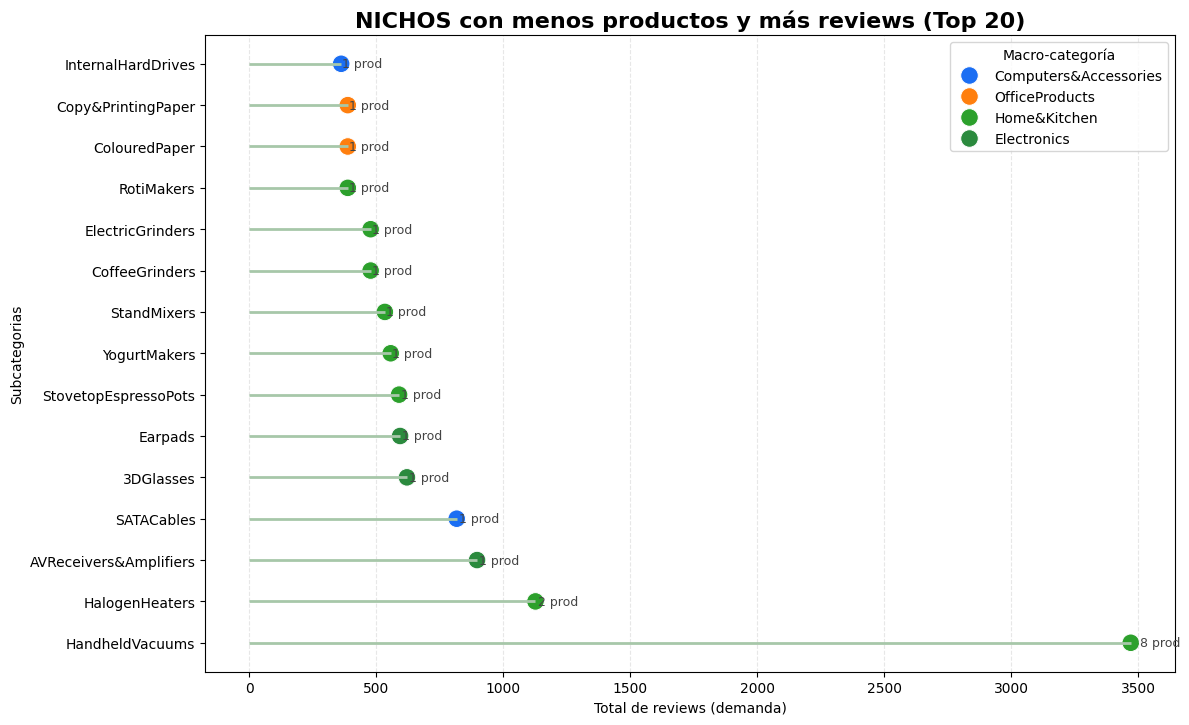

In [57]:
#Grafico para comparar categoria con menos productos y mas reviews 

#Macro-categoría
routes = amazon[["product_id", "category"]].copy()
routes["macro"] = routes["category"].astype(str).str.split("|").str[0].str.strip()
macro_by_prod = routes[["product_id", "macro"]].dropna()


leaf_macro = (
    amazon_exploded[["product_id", "category"]]
      .merge(macro_by_prod, on="product_id", how="left")
      .groupby("category")["macro"]
      .agg(lambda s: s.dropna().mode().iat[0] if s.dropna().size else "Unknown")
      .reset_index()
      .rename(columns={"macro": "macro_category"})
)

#Data para el gráfico (Top 20 hojas con poca competencia que ya calculamos)
plot_df = (
    top_nichos.merge(leaf_macro, on="category", how="left")
                  .sort_values("total_reviews", ascending=True)
                  .reset_index(drop=True)
)

#Diseño
unique_macros = plot_df["macro_category"].fillna("Unknown").unique().tolist()
palette = dict(zip(unique_macros, sns.color_palette("tab10", n_colors=len(unique_macros))))
# Colores fijos para las dos que te interesan
palette["Electronics"] = "#2b8a3e"              # verde
palette["Computers&Accessories"] = "#1b6ef3"    # azul fuerte
palette.setdefault("Unknown", "#999999")


plt.figure(figsize=(12, 8))


plt.hlines(y=plot_df["category"], xmin=0, xmax=plot_df["total_reviews"],
           color="#a7c7a9", lw=2)

sns.scatterplot(
    data=plot_df,
    x="total_reviews", y="category",
    hue="macro_category", palette=palette,
    s=160, edgecolor="white", linewidth=0.7
)


for _, r in plot_df.iterrows():
    plt.text(r["total_reviews"] * 1.01, r["category"],
             f'{int(r["num_productos"])} prod',
             va="center", fontsize=9, color="#444")

plt.title("NICHOS con menos productos y más reviews (Top 20)",
          fontsize=16, weight="bold")
plt.xlabel("Total de reviews (demanda)")
plt.ylabel("Subcategorias")
plt.grid(axis="x", linestyle="--", alpha=0.3)
plt.legend(title="Macro-categoría", loc="upper right", frameon=True)
plt.tight_layout()
plt.tight_layout(rect=(0, 0, 1, 0.92))
plt.show()


C:\Users\ferna\AppData\Local\Temp\ipykernel_42772\3666090252.py:128: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=(0,0,1,0.93))
c:\Users\ferna\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


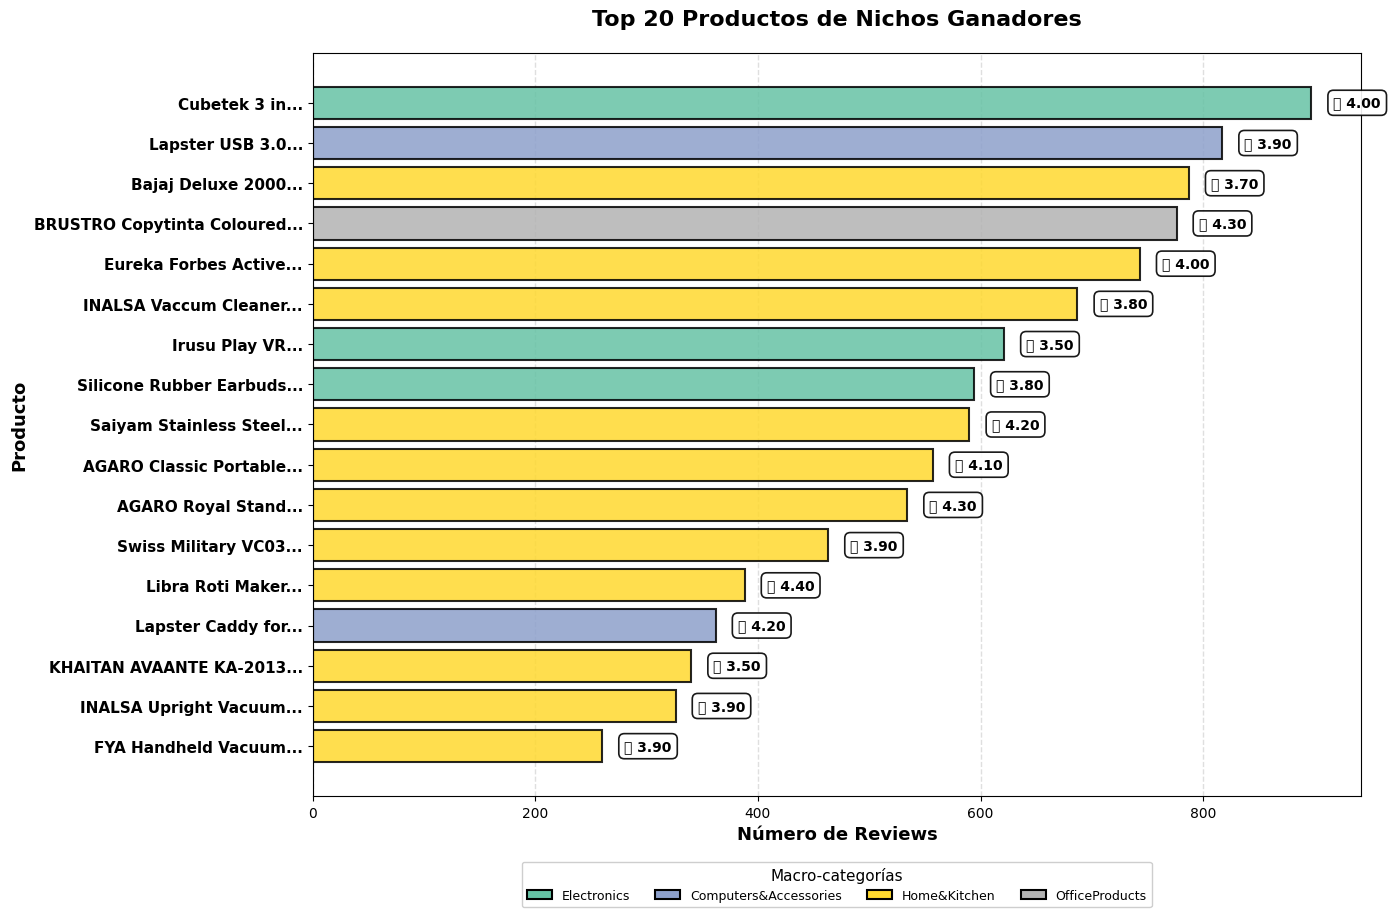

In [58]:
#Grafico que compara producto con numero de reviews y estrellas 
cats_ganadoras = top_nichos["category"].tolist()

#Nivel producto dentro de esas categorías 
dfp = amazon_exploded[amazon_exploded["category"].isin(cats_ganadoras)].copy()
dfp["rating"] = pd.to_numeric(dfp["rating"], errors="coerce")
dfp["rating_count"] = pd.to_numeric(dfp["rating_count"], errors="coerce").fillna(0)

prod = (dfp.groupby(["product_id","product_name"], as_index=False)
          .agg(
              categoria=("category","first"),
              total_reviews=("rating_count","sum"),
              rating_medio=("rating","mean")
          ))

prod = prod.dropna(subset=["rating_medio"])


rutas = amazon[["product_id","category"]].copy()
rutas["macro"] = rutas["category"].astype(str).str.split("|").str[0].str.strip()
macro_by_prod = rutas[["product_id","macro"]].dropna()

prod = prod.merge(macro_by_prod, on="product_id", how="left")
prod["macro"] = prod["macro"].fillna("Unknown")


top20_prods = prod.sort_values("total_reviews", ascending=False).head(20).copy()
top20_prods = top20_prods.iloc[1:-2].copy()



top20_prods["nombre_corto"] = top20_prods["product_name"].apply(
    lambda x: " ".join(str(x).split()[:3]) + "..."
)


SHOW_MACRO_IN_LABELS = False
if SHOW_MACRO_IN_LABELS:
    top20_prods["nombre_corto"] = top20_prods["nombre_corto"] + " · " + top20_prods["macro"]


macros_unicas = top20_prods["macro"].unique()
colores_macros = plt.cm.Set2(np.linspace(0, 1, len(macros_unicas)))
mapa_colores = dict(zip(macros_unicas, colores_macros))


top20_prods["color"] = top20_prods["macro"].map(mapa_colores)

fig, ax = plt.subplots(figsize=(14, 10))


top20_prods_sorted = top20_prods.sort_values("total_reviews", ascending=True)


bars = ax.barh(
    range(len(top20_prods_sorted)),
    top20_prods_sorted["total_reviews"],
    color=top20_prods_sorted["color"].tolist(),
    edgecolor="black",
    linewidth=1.5,
    alpha=0.85
)

ax.set_yticks(range(len(top20_prods_sorted)))
ax.set_yticklabels(top20_prods_sorted["nombre_corto"], fontsize=11, weight="semibold")


for i, (_, row) in enumerate(top20_prods_sorted.iterrows()):
    ax.text(
        row["total_reviews"] + 20,
        i,
        f"⭐ {row['rating_medio']:.2f}",
        va="center",
        fontsize=10,
        weight="bold",
        bbox=dict(boxstyle="round,pad=0.4", facecolor="white",
                  edgecolor="black", linewidth=1.2, alpha=0.9)
    )


ax.set_xlabel("Número de Reviews", fontsize=13, weight="bold")
ax.set_ylabel("Producto", fontsize=13, weight="bold")
ax.set_title(
    "Top 20 Productos de Nichos Ganadores",
    fontsize=16, weight="bold", pad=20
)

ax.grid(axis="x", linestyle="--", alpha=0.4, linewidth=1)
ax.set_axisbelow(True)

# 
from matplotlib.patches import Rectangle
legend_elements = []
for macro, color in mapa_colores.items():
    legend_elements.append(
        Rectangle((0,0), 1, 1, facecolor=color, edgecolor="black",
                  linewidth=1.5, label=macro)
    )



leg = ax.get_legend()
if leg is not None:
    leg.remove()


from matplotlib.patches import Rectangle
legend_elements = []
for macro, color in mapa_colores.items():
    legend_elements.append(
        Rectangle((0,0), 1, 1, facecolor=color, edgecolor="black",
                  linewidth=1.5, label=macro)
    )

ax.legend(
    handles=legend_elements,
    title="Macro-categorías",
    loc="upper center",            
    bbox_to_anchor=(0.5, -0.08),   
    ncol=min(4, len(legend_elements)),
    fontsize=9,
    title_fontsize=11,
    framealpha=0.95
)



plt.tight_layout(rect=(0,0,1,0.93))
plt.show()
